# Generate data

This notebook requires `BTInvert` to run the simulations to generate training data. You need to set the `code_dir` to wherever you have `BTInvert`. 

All data files generated by this notebook are available at `https://storage.googleapis.com/simpeg/uxo-heagy-et-al/{filename}`

In [1]:
code_dir = "../../UXO_protected/+BTInvertPY"

In [2]:
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d

from string import ascii_lowercase

import uxo_utils
uxo_utils.code_dir = code_dir

from uxo_utils import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix
)

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)

In [4]:
save_figures = False  # set to true to overwrite figures

## load sensor info and ordnance data

In [5]:
sensorinfo = uxo_utils.load_sensor_info()
ordnance = uxo_utils.load_ordnance_dict()

These are all the ordnance types that we have polarizabilities for 

In [6]:
ordnance.keys()

dict_keys(['105mm', '2.36-in', '2.75-in', '2.95-in', '20-lb Bomb', '25-lb Bomb', '3-in', '3.5-in', '30mm', '37mm', '4-in', '4-in Sphere', '4.2-in', '4.5-in', '4.52-in', '5-lb Bomb', '57mm', '60mm', '66mm', '75mm', '76mm', '81mm', '90mm', '106mm', 'ISO Large', 'ISO Medium', 'ISO Small', '2.25-in', '10-lb Bomb', '100-lb Bomb', 'Booster', 'Fuze', '120mm', 'Grenade', '152mm', 'Igniter Bomb', 'Landmine', 'Livens Projectile', 'Depth Charge', 'Parachute Flare', 'Rifle Grenade', '155mm', 'Dual Mode HE Rocket', 'Smoke Pot', 'Underwater Mine', '16-in', '175mm', 'Rocket Motor', '20mm', '250-lb Bomb', '25mm', '35mm', '40mm', '105mm SABOT', '5-in', '50 cal', '6-in', '7.2-in Depth Charge', '8-in', 'Bomblet', 'Booster Cup'])

## set up survey parameters
- x is cross-line
- y is inline

In [7]:
ntx = len(sensorinfo.transmitters)
ymax = 3.  # length of along-line window we collect data in
y_spacing = 0.2  # spacing between each transmitter firing
dy = y_spacing / ntx  
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)  # number of times we cycle through the all transmitters

y = np.linspace(0, ymax-dy, nloc)
x = np.zeros(nloc)
z = 0.28 * np.ones(nloc)

pitch = np.zeros(nloc)
roll = np.zeros(nloc)
yaw = np.zeros(nloc)  # moving north (sensor in typical orientation)

txnum = np.kron(np.ones(ncycles), np.arange(ntx))

In [8]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

## ordnance objects

In [9]:
times = ordnance["ISO Small"]["times"]
np.save("./data/times.npy", times)

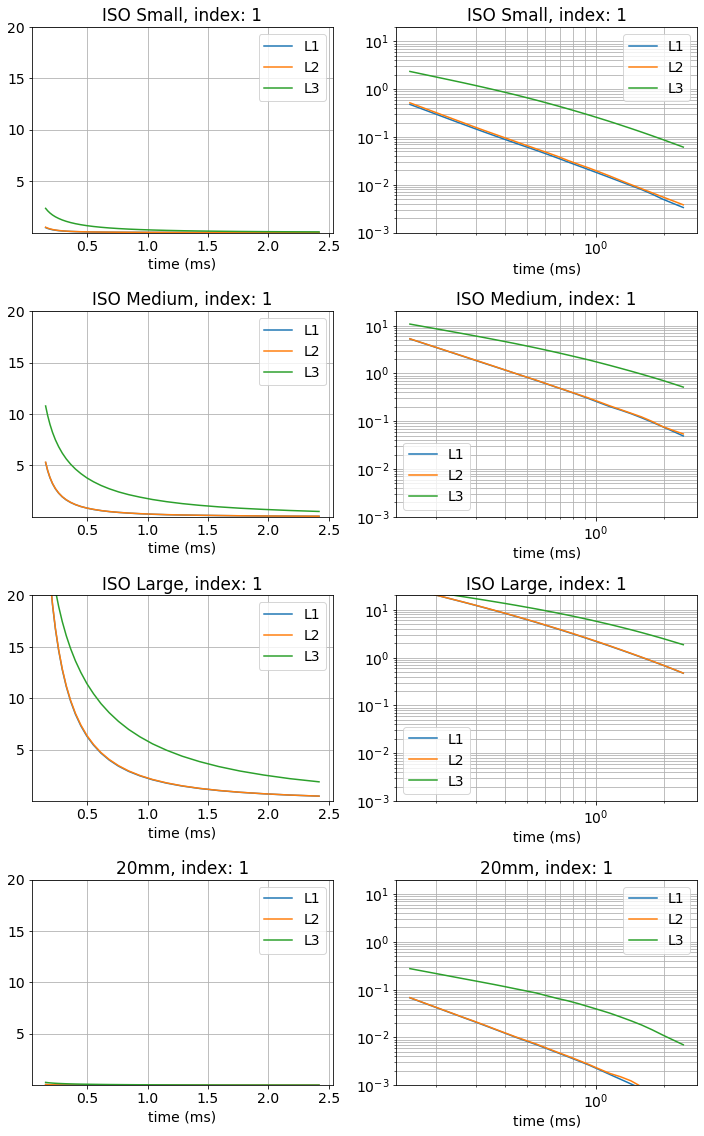

In [10]:
plot_me = {
    "ISO Small": 1,
    "ISO Medium": 1,
    "ISO Large": 1,
    "20mm": 1
}
fig, ax = plt.subplots(len(plot_me.keys()), 2, figsize=(10, 4*len(plot_me.keys())))

for i, key in enumerate(plot_me.keys()):
    for l in ["L1", "L2", "L3"]:
        L = ordnance[key][l][plot_me[key]]
        ax[i, 0].plot(times, L, label=l)
        ax[i, 1].loglog(times, L, label=l)

    for a in ax[i, :]:
        a.set_title(f"{key}, index: {1}")
        a.grid(which="both")
        a.legend()
        a.set_xlabel("time (ms)")
        a.set_ylim([1e-3, 20])
        
plt.tight_layout()

## ranges of parameters for synthetic training, test and validation sets

In [11]:
depth_ranges = [
    np.r_[0, 0.5], 
    np.r_[0, 0.5],
    np.r_[0, 0.5],
    np.r_[0, 0.5],
]

# horizontal location 
buffer = 0.5*np.r_[-1, 1]  # allow the item to be a bit outside of the data collection area
x_range = np.r_[-1.25, 1.25] + buffer
y_range = np.r_[0., ymax] + buffer

# ordnance orientation
yaw_range = np.r_[0, 2*np.pi]
pitch_range = np.r_[0, 2*np.pi]
roll_range = np.r_[0, 2*np.pi]

# variance of the noise
noise_amplitudes = np.r_[1e-5, 1e-2]

def generate_random_variables(n, bounds, log_scaled=False):
    if log_scaled is True:
        if any(bounds == 0):
            return np.zeros(n)
        bounds = np.log(bounds)
        return np.exp(bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n))
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [12]:
# size of training, test and validation sets
ntrain = 2048*4
ntest = 1024
nvalid = 1024

# labels and what they correspond to
class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "ISO Medium", 
    3: "ISO Large",
    4: "clutter",
}
n_class = len(class_dict.keys())

# items that we include in the "clutter" class
clutter_dict = {
#     0: "30mm",
    0: "20mm",
#     2: "ISO Small Plate",
    1: "ISO Small Sphere",
#     4: "Grenade"
}

In [13]:
labels_train = np.random.choice(n_class, ntrain)
labels_test = np.random.choice(n_class, ntest)
labels_valid = np.random.choice(n_class, nvalid)

def generate_parameters(labels):
    n = len(labels)
    
    depths = np.zeros(n)
    
    x = generate_random_variables(n, x_range)
    y = generate_random_variables(n, y_range)

    yaw = generate_random_variables(n, yaw_range)
    pitch = generate_random_variables(n, pitch_range)
    roll = generate_random_variables(n, roll_range)
    
    noise_amplitude = generate_random_variables(n, noise_amplitudes, True)
    
    polarizations = np.zeros(n, dtype=int)
    clutter = np.zeros(n, dtype=int)
    
    for i in np.unique(labels):
        ii = labels == i  # indices of the labels
        
        if class_dict[i] != "not TOI":
            depths[ii] = generate_random_variables(ii.sum(), depth_ranges[i-1])
            
            if class_dict[i] == "clutter":
                j = np.random.choice(len(clutter_dict.keys()), ii.sum())
                clutter[ii] = j
                for key, val in clutter_dict.items():
                    jj = j == key
                    if val == "30mm" or val == "20mm":
                        polarizations[ii][jj] = np.ones(jj.sum())
                    else: 
                        polarizations[ii][jj] = np.random.choice(len(ordnance["ISO Small"]["L3"]), jj.sum())
            else:
                polarizations[ii] = np.random.choice(len(ordnance[class_dict[i]]["L3"]), ii.sum())
                                 
    
    return pd.DataFrame({
        "label": labels,
        "depth": depths,
        "x": x,
        "y": y,
        "z": -depths,
        "yaw": yaw,
        "pitch": pitch,
        "roll": roll, 
        "noise_amplitude": noise_amplitude,
        "polarizations": polarizations,
        "clutter_type": clutter
    })

In [14]:
np.save("./data/labels_train.npy", labels_train)
np.save("./data/labels_test.npy", labels_test)
np.save("./data/labels_valid.npy", labels_valid)

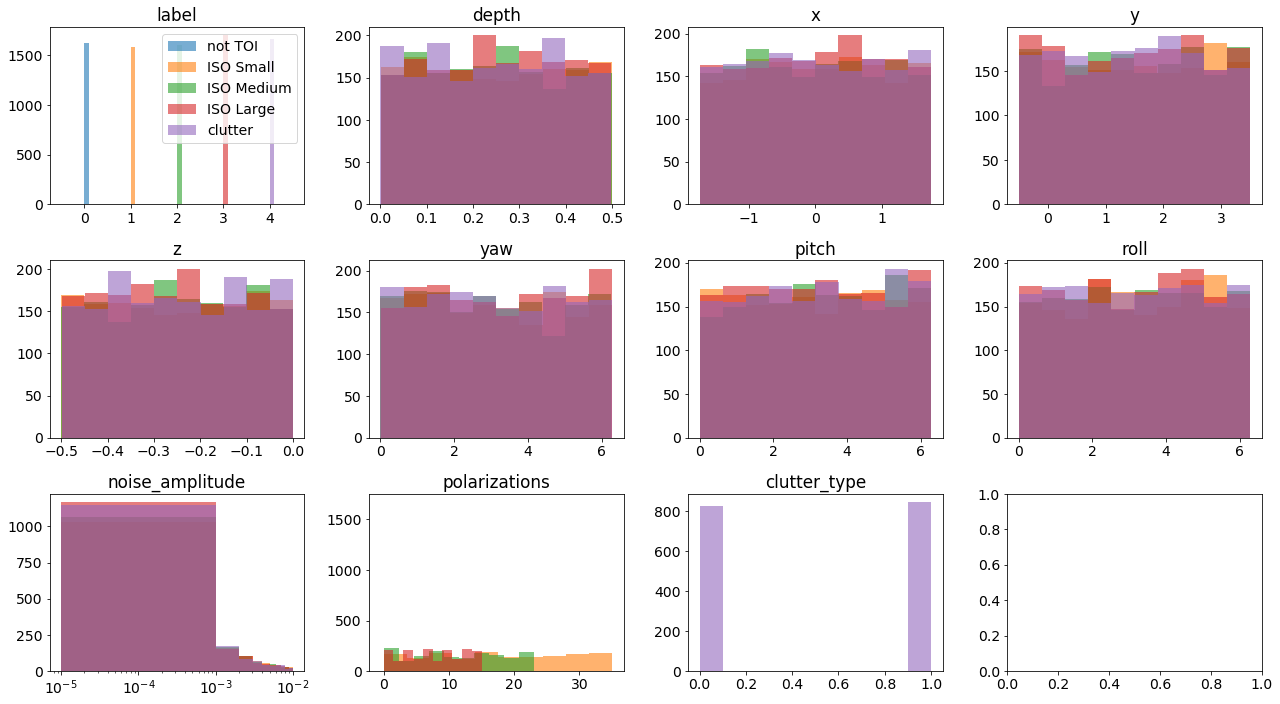

In [15]:
params_train = generate_parameters(labels_train) 
params_test = generate_parameters(labels_test) 
params_valid = generate_parameters(labels_valid) 

fig, ax = plt.subplots(3, 4, figsize=(18, 10))
ax = ax.flatten()

i = 0
for key, val in params_train.items():
    for j in range(n_class):
        inds = labels_train == j
        if key != "label" and j == 0: 
            pass  # these parameters are irrelevant if there is no object
        elif key == "noise_amplitude":
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
            ax[i].set_xscale("log")
        elif (key == "clutter_type") and (j == n_class-1):
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
        elif key != "clutter_type":
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
    ax[i].set_title(key)
    i += 1

ax[0].legend(list(class_dict.values()))
plt.tight_layout()

### save training, test and validation parameters

In [16]:
params_train.to_hdf("./data/params_train.h5", key="df", mode="w")
params_test.to_hdf("./data/params_test.h5", key="df", mode="w")
params_valid.to_hdf("./data/params_valid.h5", key="df", mode="w")

## set up forward simulations

In [17]:
def noise_model(times, amplitude=0.1, slope=-1, intercept=-0.5):
    return amplitude * np.exp(slope * np.log(times) + intercept)

In [18]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) 

# convienence object for inputs to fwd modelling 
st = FModParam(sensorinfo, pos, mnum, times, Tx_indices_rot, Rx_indices_rot)  

In [19]:
def run_simulations(parameters, st=st, mnum=mnum, ncycles=ncycles):
    data = []
    noise_data = []
    for i, l in enumerate(parameters["label"]):
        if l == 0:
            # this can later be replaced with random noise or other structured but uninteresting signal
            V = np.zeros((mnum.max()+1, ncycles, len(times)))
        else: 
            xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
            ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
            pi = parameters["polarizations"][i]
            
            if class_dict[l] != "clutter":
                L3 = ordnance[class_dict[l]]["L3"][pi]
                L2 = ordnance[class_dict[l]]["L2"][pi]
                L1 = ordnance[class_dict[l]]["L1"][pi]
            else:
                clutter_type = parameters["clutter_type"][i]
                clutter_name = clutter_dict[clutter_type]
                if clutter_name in ["30mm", "20mm"]:
                    L3 = ordnance[clutter_name]["L3"][pi]
                    L2 = ordnance[clutter_name]["L2"][pi]
                    L1 = ordnance[clutter_name]["L1"][pi]
                elif clutter_name == "ISO Small Plate":
                    L3 = ordnance["ISO Small"]["L3"][pi]
                    L2 = ordnance["ISO Small"]["L3"][pi] # L2 == L3 is like a plate
                    L1 = ordnance["ISO Small"]["L1"][pi]
                elif clutter_name == "ISO Small Sphere":
                    L3 = ordnance["ISO Small"]["L1"][pi]
                    L2 = ordnance["ISO Small"]["L1"][pi] # L1 == L2 == L3 is a sphere
                    L1 = ordnance["ISO Small"]["L1"][pi] # L1 == L2 == L3 is a sphere
                                  

            mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
            V = forwardWithQ(mod, st) # nT/s (some version of db/dt)
            V = V.reshape(ncycles, mnum.max()+1, len(times))
            V = np.swapaxes(V, 0, 1)
        data.append(V)
        noise_data.append(
            V + 
            np.random.randn(np.prod(V.shape)).reshape(V.shape) * 
            noise_model(times, amplitude=parameters["noise_amplitude"][i])
        )
    return data, noise_data

In [20]:
%%time
data_clean_train, data_train = run_simulations(params_train)

CPU times: user 2min 28s, sys: 6.43 s, total: 2min 34s
Wall time: 41.2 s


In [21]:
%%time
data_clean_test, data_test = run_simulations(params_test)
data_clean_valid, data_valid = run_simulations(params_valid)

CPU times: user 39 s, sys: 2 s, total: 41 s
Wall time: 11.4 s


In [22]:
np.save("./data/data_clean_train.npy", np.stack(data_clean_train, 0))
np.save("./data/data_train.npy", np.stack(data_train, 0))

np.save("./data/data_clean_test.npy", np.stack(data_clean_test, 0))
np.save("./data/data_test.npy", np.stack(data_test, 0))

np.save("./data/data_clean_valid.npy", np.stack(data_clean_valid, 0))
np.save("./data/data_valid.npy", np.stack(data_valid, 0))

## plot some sample data

In [23]:
pos = np.swapaxes(pos.reshape(ncycles, mnum.max()+1, 3), 0, 1)
np.save("./data/pos.npy", pos)

In [24]:
dind = 28
d = data_train[dind]

print(f"class: {class_dict[labels_train[dind]]}, data shape: {d.shape}")

params_train.iloc[dind]

class: ISO Medium, data shape: (165, 15, 27)


label              2.000000
depth              0.189870
x                 -0.902959
y                  1.485053
z                 -0.189870
yaw                5.784394
pitch              4.263859
roll               0.995787
noise_amplitude    0.000015
polarizations      9.000000
clutter_type       0.000000
Name: 28, dtype: float64

In [25]:
# tx_num, rx_num, rx_comp, rxcube
sensor_table = sensorinfo.measNum2TxRxRxcCube()
np.save("./data/sensor_table.npy", sensor_table)

Text(0.5, 0.92, 'Transmitter 2, Target 28: ISO Medium')

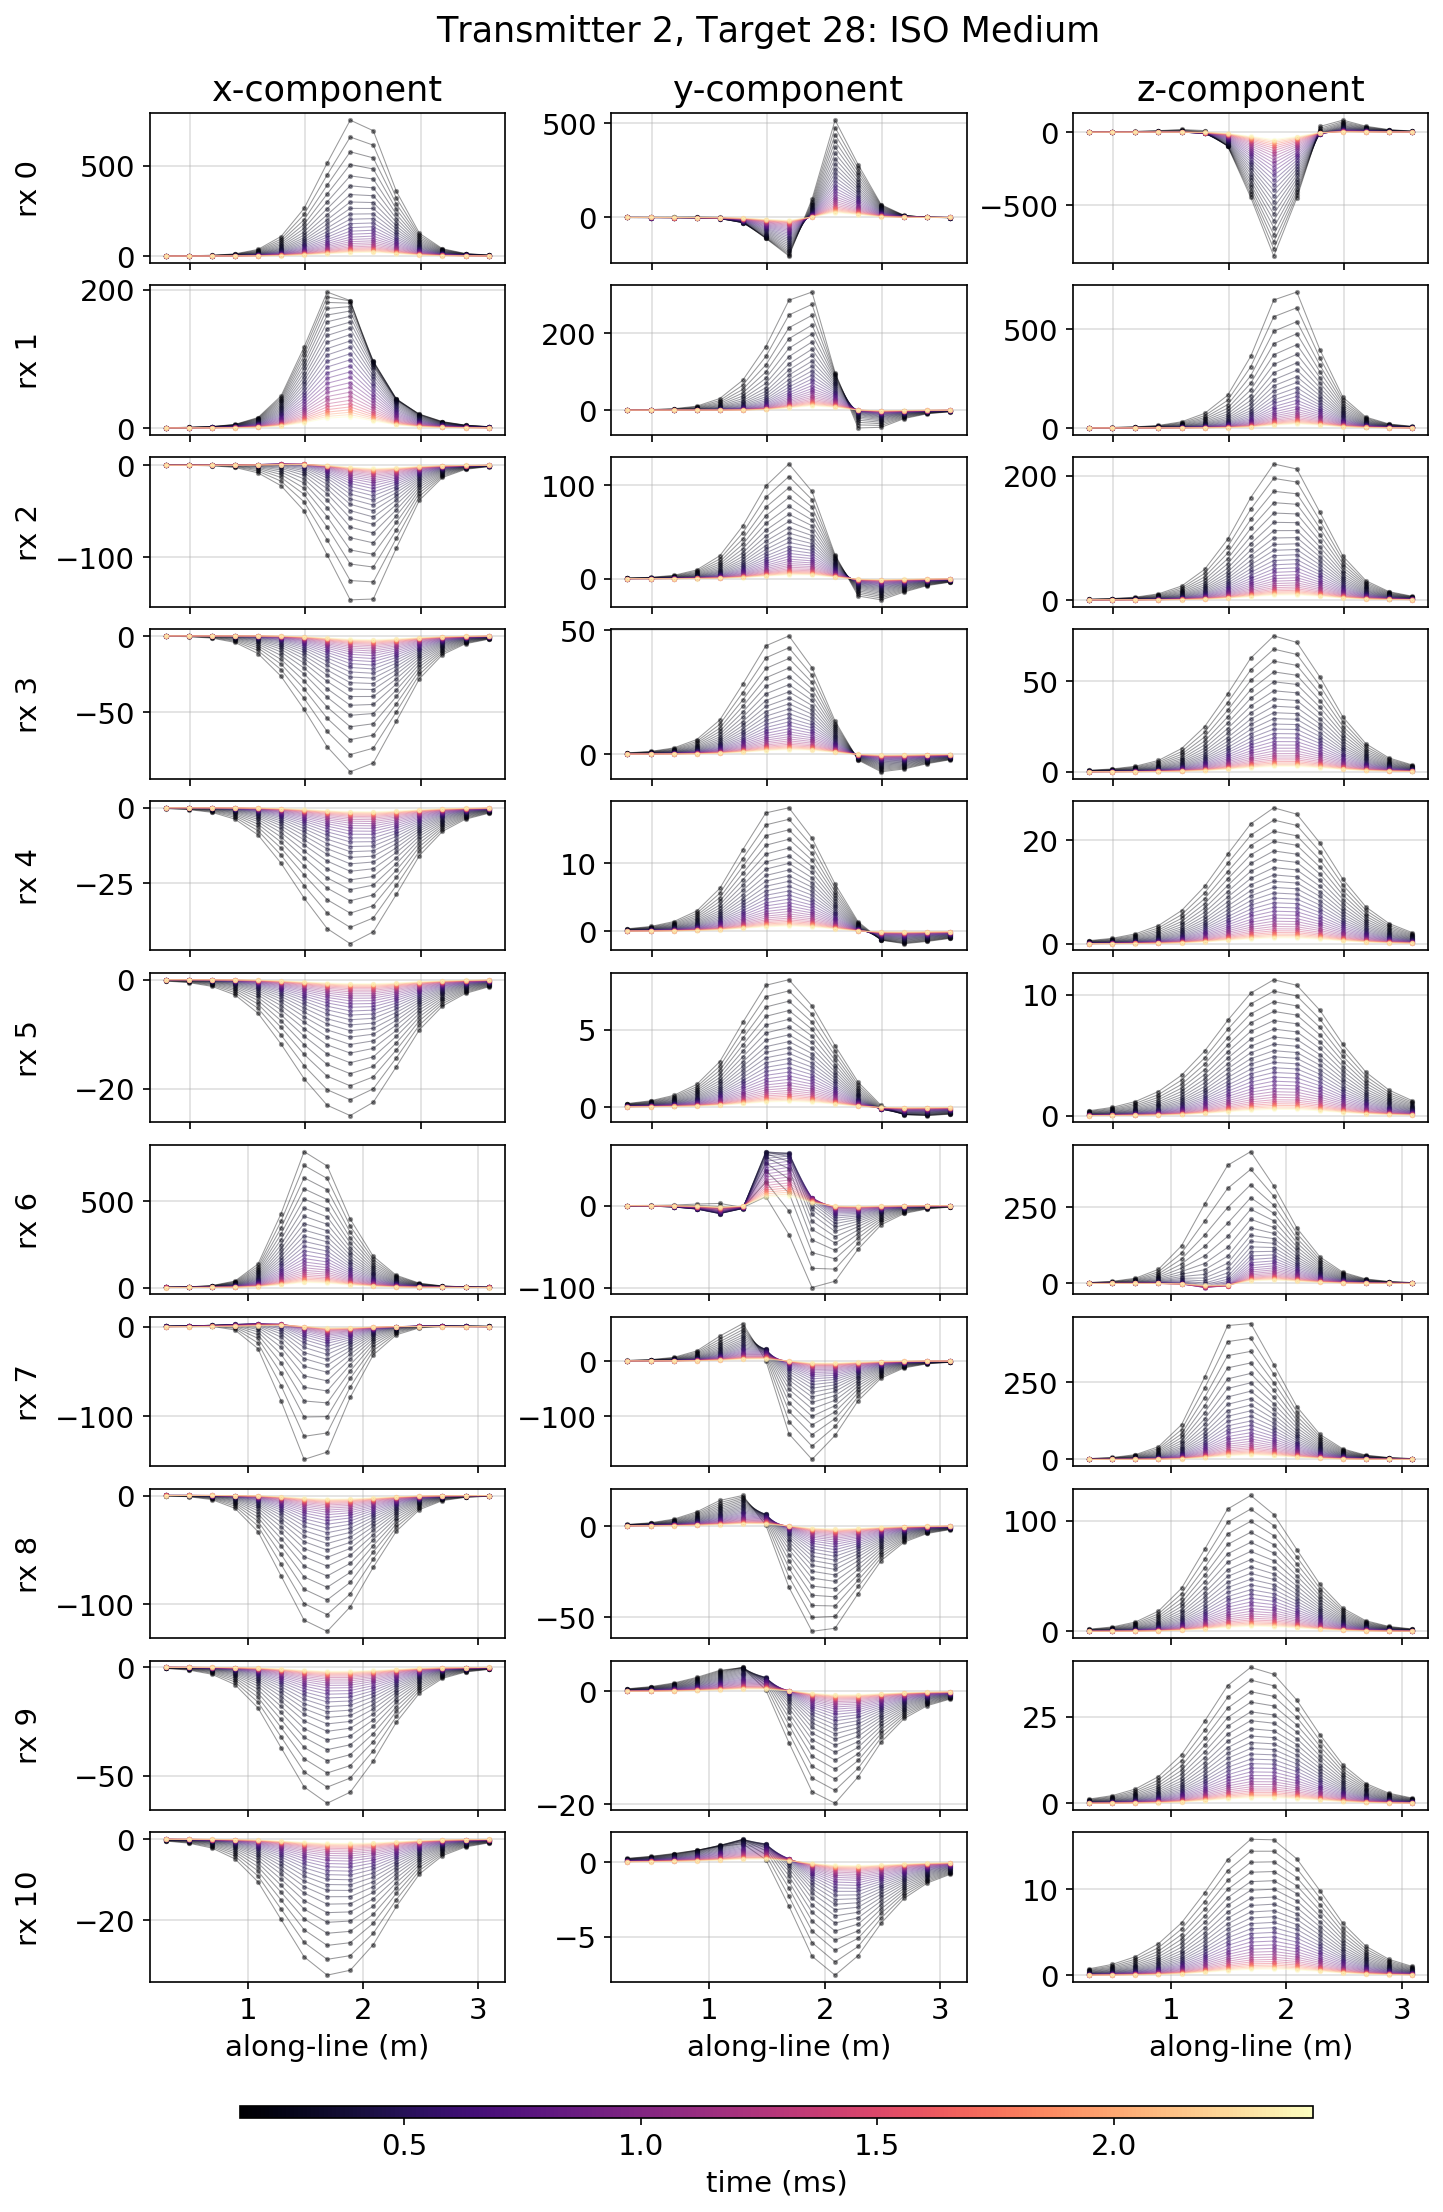

In [26]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx), dpi=150)
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 1
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

d = data_clean_train[dind][:, :, :]

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        for t in range(len(times)):
            a.plot(
                pos[mnumind, :, 1], d[mnumind, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


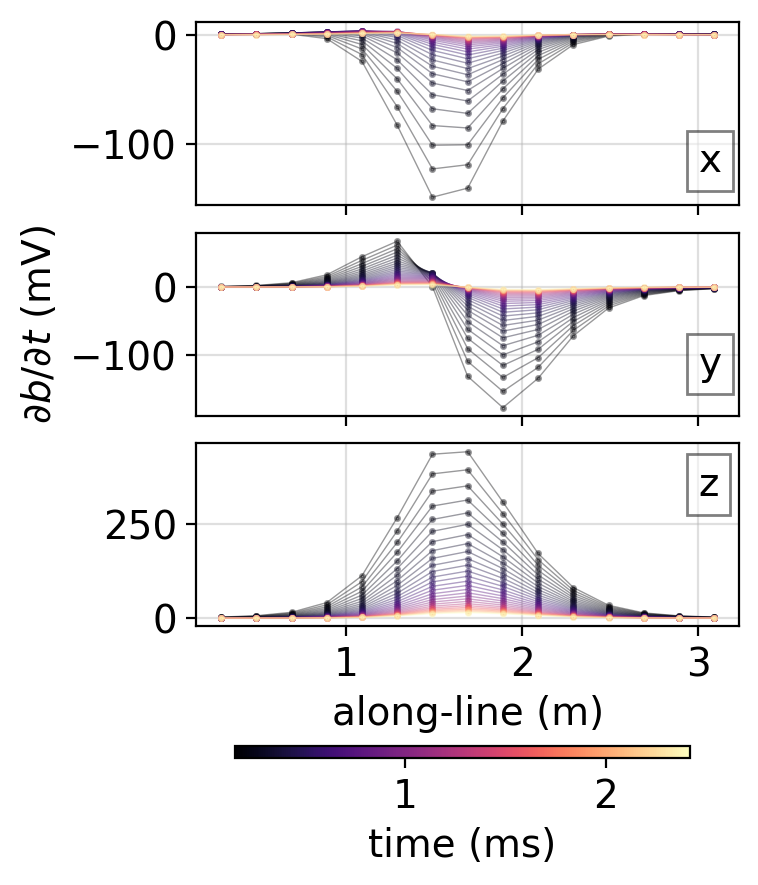

In [27]:

fig, ax = plt.subplots(3, 1, figsize=(3.5, 4), dpi=200, sharex=True)
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 1
plot_rx = 7
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

d = data_clean_train[dind][:, :, :]

# for rx in range(nrx):
ii = tx_inds & (sensor_table[:, 3] == plot_rx)

for a, comp in zip(ax, [0, 1, 2]):
    mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
    for t in range(len(times)):
        a.plot(
            pos[mnumind, :, 1], d[mnumind, :, t], 
            color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
        )

    a.grid(which="both", alpha=0.4)

    if comp == 0:
        a.text(3, -125, "x", bbox=dict(facecolor='w', alpha=0.5))
    if comp == 1:
        a.set_ylabel("$\partial {b}/\partial t$ (mV)")
        a.text(3, -130, "y", bbox=dict(facecolor='w', alpha=0.5))
    elif comp == 2:
        a.set_xlabel("along-line (m)")
        a.text(3, 325, "z", bbox=dict(facecolor='w', alpha=0.5))
    
#     a.yaxis.set_label_coords(-0.2, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, -0.04, 0.65, 0.015])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

if save_figures: 
    fig.savefig("figures/data_sample", bbox_inches="tight")


## Generate a line of synthetic data

In [28]:
ymax_profile = 40
nloc_profile = int(ymax_profile/dy)
ncycles_profile = int(nloc_profile/ntx)

y_profile = np.linspace(0, ymax_profile-dy, nloc_profile)
x_profile = np.zeros(nloc_profile)
z_profile = 0.28 * np.ones(nloc_profile)

pitch_profile = np.zeros(nloc_profile)
roll_profile = np.zeros(nloc_profile)
yaw_profile = np.zeros(nloc_profile)  # moving north (sensor in typical orientation)

txnum_profile = np.kron(np.ones(ncycles_profile), np.arange(ntx))

In [29]:
# Convert sensor location coordinates to Rx locations
pos_profile, mnum_profile = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x_profile, 
    y = y_profile, 
    z = z_profile, 
    pitch = pitch_profile, 
    roll = roll_profile, 
    yaw = yaw_profile,
    txnum = txnum_profile
)

pitch_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(pitch_profile)])
roll_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(roll_profile)])
yaw_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(yaw_profile)])
pos_profile = np.concatenate(pos_profile,axis=0)

In [30]:
depths_profile = np.r_[0.4, 0.2, 0.7]
params_profile = pd.DataFrame({
    "label": [1, 4, 2],
    "depth": depths_profile,
    "x": np.r_[0, 0, 0],
    "y": np.r_[5, 17, 26],
    "z": -depths_profile,
    "yaw": 0*np.r_[0, np.pi/4, np.pi], #, 0, np.pi/4, np.pi/2],
    "pitch": np.r_[0, 0, 0], #, 0, 0, 0],
    "roll": np.r_[0, 0, 0], #, 0, 0, 0],
    "noise_amplitude": 0.01*np.r_[1, 1, 1], #, 1, 1, 1],
    "polarizations": [0, 0, 0], #, 0, 0, 0],
    "clutter_type": np.zeros(len(depths_profile))
})
params_profile

,label,depth,x,y,z,yaw,pitch,roll,noise_amplitude,polarizations,clutter_type
0,1,0.4,0,5,-0.4,0.0,0,0,0.01,0,0.0
1,4,0.2,0,17,-0.2,0.0,0,0,0.01,0,0.0
2,2,0.7,0,26,-0.7,0.0,0,0,0.01,0,0.0


In [31]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot_profile, Rx_indices_rot_profile = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum_profile, rlist=pos_profile, pitch=pitch_profile, roll=roll_profile, yaw=yaw_profile
) 

# convienence object for inputs to fwd modelling 
st_profile = FModParam(sensorinfo, pos_profile, mnum_profile, times, Tx_indices_rot_profile, Rx_indices_rot_profile)  

In [32]:
data_profile, noise_profile = run_simulations(params_profile, st=st_profile, mnum=mnum_profile, ncycles=ncycles_profile)

In [33]:
data_profile = [d + n for d, n in zip(data_profile, noise_profile)]
data_profile[0].shape

(165, 200, 27)

In [34]:
X_profile = pos_profile[:, 0].reshape((165, ncycles_profile), order="F")
Y_profile = pos_profile[:, 1].reshape((165, ncycles_profile), order="F")

In [35]:
D_profile = sum(data_profile)
D_profile.shape

(165, 200, 27)

In [36]:
window_width_profile = int(ymax/y_spacing)
w_step_profile = 3
n_windows_profile = (X_profile.shape[1]-window_width_profile)//w_step_profile
print(n_windows_profile)

61


In [37]:
np.savez(
    "./data/data_profile.npz", x=X_profile, y=Y_profile, data=D_profile
)
params_profile.to_hdf("./data/params_profile.h5", key="df", mode="w")

(-2, 42)

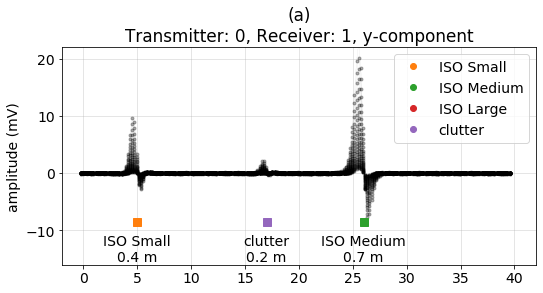

In [38]:
mnum_plot = 12
fig, ax = plt.subplots(1, 1, figsize=(8.5, 4))

ordnance_labels = [
    Line2D(
        [0], [0], marker='o', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=value
    ) for key, value in class_dict.items() if key != 0
]

ax.plot(Y_profile[mnum_plot, :], D_profile[mnum_plot, :, :], marker='.', color="k", alpha=0.3, lw=0.1)
ax.grid("both", alpha=0.4)

txnumplot = sensor_table[mnum_plot, 0]
rxnumplot = sensor_table[mnum_plot, 3]
rxcompplot = sensor_table[mnum_plot, 2]
ax.set_title(f"(a)\nTransmitter: {txnumplot}, Receiver: {rxnumplot}, y-component")

ax.set_ylabel("amplitude (mV)")

for i in range(len(depths_profile)):
    label = params_profile["label"][i]
    ax.plot(params_profile["y"][i], -8.5, f"sC{label}", ms=8)
    ax.text(params_profile["y"][i], -16, class_dict[label] + f"\n{depths_profile[i]:1.1f} m", ha="center", va="bottom")

ax.legend(handles=ordnance_labels)

# ax.set_xlim([12.5, 17.5])
ax.set_ylim([-16, 22])
ax.set_xlim([-2, 42])
#     a.set_xlim([25, 31])


## generate synthetic data based on the test site

In [39]:
data_directory = "../../UXO_protected/data-blacktusk"
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [40]:
# H5 functions
def proc_attr(inp):
    """HDF5 - Process attributes for the input group and return them in a dictionary."""
    dic = {}
    for att in inp.attrs.keys():
        if inp.attrs[att].dtype.char == 'S':
            dic[att] = [x.strip() for x in inp.attrs[att].tostring().decode('ascii').split(',')]
        else:
            dic[att] = inp.attrs[att][0] if isinstance(inp.attrs[att],np.ndarray) and inp.attrs[att].size==1 else inp.attrs[att]
    return dic
    pass

def proc_group(inp):
    """HDF5 - A recursive function for reading datasets and attributes into a dictionary."""
    dic = {}
    dic.update(proc_attr(inp))
    for key in inp.keys():
        if isinstance(inp[key], h5py.Group):
            dic.update({key:proc_group(inp[key])})
        else:
            dic[key] = inp[key][()]
        pass
    return dic

In [41]:
dfile = os.path.join(data_directory, 'Testplot5F.h5')
f = h5py.File(dfile, 'r')
dic = proc_group(f)
f.close()

In [42]:
# Generate the sensorinfo structure
sensor_name = dic['SensorName'][0]
sensor_config = dic['SensorConfig'][0]
afile = os.path.join(code_dir,'config','sensor_definitions','{}___{}.yaml'.format(sensor_name,sensor_config))
sensorinfo = SensorInfo.fromYAML(afile)[0]

print(sensor_name)

UltraTEMArrayNA


In [43]:
xyz_dict = dic["XYZ"]
ch = xyz_dict['Info']['ChannelNames']
datai = xyz_dict['Info']['Data']['ChannelIndex'].flatten().astype(int)-1 # These are indices to the decay data
yawi = int(xyz_dict['Info']['Yaw']['ChannelIndex'])-1 # index to the yaw channel
pitchi = int(xyz_dict['Info']['Pitch']['ChannelIndex'])-1 
rolli = int(xyz_dict['Info']['Roll']['ChannelIndex'])-1 
mni = int(xyz_dict["Info"]["MeasNum"]["ChannelIndex"])-1
easting = int(xyz_dict["Info"]["Easting"]["ChannelIndex"])-1
northing = int(xyz_dict["Info"]["Northing"]["ChannelIndex"])-1
linesi = int(xyz_dict["Info"]["Line"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"])-1
tx_num = int(xyz_dict["Info"]["TxNum"]["ChannelIndex"])-1
rx_comp = int(xyz_dict["Info"]["RxCNum"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"]) - 1

times = np.array(dic['SensorTimes'].flatten())
print(times.min(), times.max(), len(times))

0.154 2.42 27


In [44]:
xyz_data = xyz_dict["Data"]
mn = xyz_data[mni, :].astype(int) - 1

In [45]:
line_id = 1004 
line_inds = xyz_data[linesi, :] == line_id
print(sum(line_inds))

60390


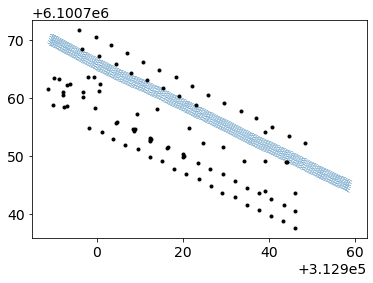

In [46]:
fig, ax = plt.subplots(1, 1)
ax.plot(xyz_data[easting, line_inds], xyz_data[northing, line_inds], '.', alpha=0.1, ms=0.2)
ax.plot(groundtruth["Easting"], groundtruth["Northing"], 'k.')

In [47]:
# local coordinates for the data set 
x0, y0 = np.mean(xyz_data[easting, :]), np.mean(xyz_data[northing, :])
local_easting = xyz_data[easting, :] - x0
local_northing = xyz_data[northing, :] - y0

slope, intercept, _, _, _ = stats.linregress(local_easting, local_northing)
print(slope, intercept)

-0.3486944749895923 6.346738382583072e-10


In [48]:
theta = np.arctan(slope)+np.pi/2
local_x = np.cos(theta) * local_easting + np.sin(theta) * local_northing
local_y = -np.sin(theta) * local_easting + np.cos(theta) * local_northing

local_ground_truth_easting = np.array(groundtruth["Easting"] - x0)
local_ground_truth_northing = np.array(groundtruth["Northing"] - y0)
local_ground_truth_x = np.cos(theta) * local_ground_truth_easting + np.sin(theta) * local_ground_truth_northing
local_ground_truth_y = -np.sin(theta) * local_ground_truth_easting + np.cos(theta) * local_ground_truth_northing


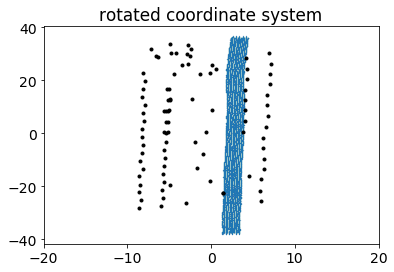

In [49]:
line_x = local_x[line_inds]
line_y = local_y[line_inds]

mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1)
ax.plot(line_x, line_y, '.', ms=0.1)
ax.set_xlim(np.r_[-20, 20])
ax.set_title("rotated coordinate system")

ax.plot(local_ground_truth_x, local_ground_truth_y, 'k.', label="ordnance")

In [50]:
# target data shape 165 X nlocs X nTimes 
# grab by measurement number 
# then re-stack

x_locs = []
y_locs = []
data_list = []
line_data = xyz_data[datai, :][:, line_inds]

for mnind in range(mn.max() + 1):
    mninds = mn_line == mnind
    x_locs.append(line_x[mninds])
    y_locs.append(line_y[mninds])
    data_list.append(line_data[:, mninds].T)

In [51]:
X_locs = np.vstack(x_locs)
Y_locs = np.vstack(y_locs)
S_data = np.stack(data_list, axis=0)
print(S_data.shape, X_locs.shape)

(165, 366, 27) (165, 366)


In [52]:
np.unique(groundtruth["ItemBuried"])

array(['20mm', 'EOD9115', 'EOD9145', 'EOD9146', 'EOD9147', 'EOD9148',
       'EOD9149', 'EOD9150', 'EOD9151', 'EOD9152', 'EOD9153', 'EOD9154',
       'EOD9156', 'EOD9157', 'EOD9160', 'East 5m', 'Large ISO',
       'Medium ISO', 'Native1', 'Native12', 'Native2', 'Native3',
       'Native4', 'Native5', 'Native8', 'North 5m', 'Railway',
       'Small ISO', 'South 5m', 'West 5m'], dtype=object)

In [53]:
# make a representative synthetic 

synthetic_keys = ["20mm", "Small ISO", "Medium ISO", "Large ISO"]
# synthetic_starts_with = ["Native"]

In [54]:
synthetic_ground_truth = {}
synthetic_easting = []
synthetic_northing = []
synthetic_x = []
synthetic_y = []
synthetic_item = []
synthetic_depth = []

for i, item in enumerate(groundtruth["ItemBuried"]):
    if item in synthetic_keys or item.startswith("Native"):
        synthetic_easting.append(groundtruth["Easting"][i])
        synthetic_northing.append(groundtruth["Northing"][i])
        synthetic_x.append(local_ground_truth_x[i])
        synthetic_y.append(local_ground_truth_y[i])
        
        d = groundtruth["Depth (m)"][i]
        if np.isnan(d):
            d = 0.3 
        synthetic_depth.append(d)
        
        if item.startswith("Native"):
            synthetic_item.append("Small ISO")
        else: 
            synthetic_item.append(item)

synthetic_ground_truth = {
    "easting": np.array(synthetic_easting) - x0,
    "northing": np.array(synthetic_northing) - y0,
    "x": np.array(synthetic_x), 
    "y": np.array(synthetic_y), 
    "depth": np.array(synthetic_depth),
    "item": np.array(synthetic_item)
}

In [55]:
synthetic_subset = pd.DataFrame({
    key: val[::5] for key, val in synthetic_ground_truth.items()
})

synthetic_subset.to_hdf("./data/synthetic_subset.h5", key="df", mode="w")

In [56]:
synthetic_subset

,easting,northing,x,y,depth,item
0,1.341747,-6.212464,-5.424297,-3.312400,0.15,20mm
1,15.381740,-11.371703,-5.673172,-18.268242,0.25,20mm
2,-21.141159,-1.004958,-7.909693,19.631488,0.18,Small ISO
3,-7.150652,-5.972098,-7.993473,4.785622,0.40,Small ISO
4,6.913338,-11.410477,-8.498022,-10.284787,0.52,Small ISO
5,21.046976,-16.254846,-8.418751,-25.225381,0.75,Small ISO
6,-15.168495,12.697189,6.994963,18.503307,0.48,Medium ISO
7,3.542912,5.355300,6.223210,-1.582124,0.80,Medium ISO
8,22.364635,-1.598162,5.854549,-21.643828,1.25,Medium ISO
9,-14.234487,9.296701,4.091603,16.501759,1.07,Large ISO


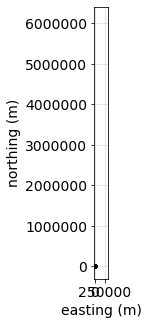

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(xyz_data[easting], xyz_data[northing], '.', alpha=0.1, ms=0.2)
ax.plot(synthetic_subset["easting"], synthetic_subset["northing"], 'k.')
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
ax.grid("both", alpha=0.4)
ax.set_aspect(1)

In [58]:
# generate synthetic data
label = []
depth = []
x = []
y = []
yaw = []
pitch = []
roll = []
polarizations = []


for i, item in enumerate(synthetic_subset["item"]):
    if item in ["Small ISO", "Native"]:
        label.append(1)
    elif item == "Medium ISO":
        label.append(2)
    elif item == "Large ISO":
        label.append(3)
    elif item == "20mm":
        label.append(4)
    else: 
        print(item)
    polarizations.append(0)
    yaw.append(0)
    pitch.append(0)
    roll.append(0)

params_synthetic = pd.DataFrame({
    "label": np.array(label),
    "depth": synthetic_subset["depth"],
    "x": synthetic_subset["x"],
    "y": synthetic_subset["y"],
    "z": -synthetic_subset["depth"],
    "yaw": np.zeros(len(label)),
    "pitch": np.zeros(len(label)),
    "roll": np.zeros(len(label)),
    "noise_amplitude": 1e-3*np.ones(len(label)),
    "polarizations": polarizations,
})

In [59]:
# make the synthetic local locations

pos_synthetic = []
mnum_synthetic = []
yaw_synthetic = []
lines_synthetic = []

for line_id in np.unique(xyz_data[linesi, :]): 
    line_inds = xyz_data[linesi, :] == line_id
    ncycles = int(np.ceil(line_inds.sum()/165))
    x_line = np.mean(local_x[line_inds])
    y0i = np.min(local_y[line_inds])
    nloc = int(ncycles * ntx)
    
    xi = np.ones(nloc)*x_line
    yi = y_spacing/ntx * np.arange(0, nloc) + y0i
    zi = 0.28 * np.ones(nloc)

    pitchi = np.zeros(nloc)
    rolli = np.zeros(nloc)
    if np.mean(xyz_data[linesi, :]) < 0:
        yawi = np.pi*np.ones(nloc)
    else: # moving south 
        yawi = np.zeros(nloc)  # moving north (sensor in typical orientation)

    txnumi = np.kron(np.ones(ncycles), np.arange(int(ntx)))

    posi, mnumi = sensorCoords2RxCoords(
        sensorinfo=sensorinfo,
        x = xi, 
        y = yi, 
        z = zi, 
        pitch = pitchi, 
        roll = rolli, 
        yaw = yawi,
        txnum = txnumi
    )
    
    yaw_synthetic.append(yawi)
    pos_synthetic.append(posi)
    mnum_synthetic.append(mnumi)
    lines_synthetic.append(line_id*np.ones_like(yawi))

In [60]:
pos_synthetic = np.vstack(pos_synthetic)
mnum_synthetic = np.hstack(mnum_synthetic)
yaw_synthetic = np.hstack(yaw_synthetic)
lines_synthetic = np.hstack(lines_synthetic)

In [61]:
yaw_synthetic = np.concatenate([np.tile(x,pos_synthetic[i].shape[0]) for i,x in enumerate(yaw_synthetic)])
lines_synthetic = np.concatenate([np.tile(x,pos_synthetic[i].shape[0]) for i,x in enumerate(lines_synthetic)])
pos_synthetic = np.concatenate(pos_synthetic,axis=0)

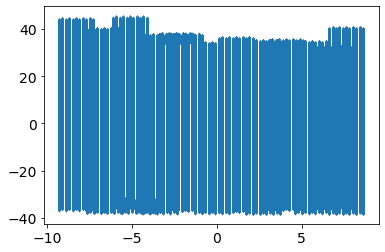

In [62]:
plt.plot(pos_synthetic[:, 0], pos_synthetic[:, 1], '.', ms=1, alpha=0.5)

In [63]:
# mnum_synthetic = xyz_data[mni, :].astype(int) - 1
# pos_synthetic = np.hstack([local_x[:, None], local_y[:, None], 0.28*np.ones((len(mnum_synthetic),1))])

Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum_synthetic, rlist=pos_synthetic, 
    pitch=np.zeros_like(yaw_synthetic), 
    roll=np.zeros_like(yaw_synthetic), 
    yaw=yaw_synthetic
) 

# convienence object for inputs to fwd modelling 
st_synthetic = FModParam(sensorinfo, pos_synthetic, mnum_synthetic, times, Tx_indices_rot, Rx_indices_rot)  

In [64]:
def generate_synthetic_data(parameters, st, mnum):
    data = None
    noise_data = None
    for i, l in enumerate(parameters["label"]):
        print(f"{i}: simulating {l}")
        xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
        ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
        pi = parameters["polarizations"][i]

        if class_dict[l] != "clutter":
            L3 = ordnance[class_dict[l]]["L3"][pi]
            L2 = ordnance[class_dict[l]]["L2"][pi]
            L1 = ordnance[class_dict[l]]["L1"][pi]
        else:
            clutter_name = "20mm"
            L3 = ordnance[clutter_name]["L3"][pi]
            L2 = ordnance[clutter_name]["L2"][pi]
            L1 = ordnance[clutter_name]["L1"][pi]

        mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
        V = forwardWithQ(mod, st) # mV
        if np.isnan(V).any():
            print(i)
            raise Exception 
        
        noisy_V = (
            V + 
            np.random.randn(np.prod(V.shape)).reshape(V.shape) * 
            noise_model(times, amplitude=parameters["noise_amplitude"][i])
        )
        if data is None:
            data = V
            noise_data = noisy_V
        else:
            data = data + V
            noise_data = noise_data + noisy_V
    return data, noise_data

In [65]:
synthetic_data, synthetic_data_noisy = generate_synthetic_data(
    params_synthetic, st_synthetic, mnum_synthetic
)

0: simulating 4
1: simulating 4
2: simulating 1
3: simulating 1
4: simulating 1
5: simulating 1
6: simulating 2
7: simulating 2
8: simulating 2
9: simulating 3
10: simulating 1
11: simulating 1
12: simulating 1
13: simulating 4
14: simulating 4


In [66]:
np.savez(
    "./data/synthetic_test_plot.npz",
    synthetic_data=synthetic_data,
    synthetic_data_noisy=synthetic_data_noisy,
    pos_synthetic=pos_synthetic, 
    mnum_synthetic=mnum_synthetic,
    lines_synthetic=lines_synthetic,
    theta=theta
)